In [3]:
import numpy as np
import cv2 as cv
from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
import medpy
%matplotlib inline

Exploring Data from  Data/usliverseq/volunteer01
The other volunteers seem to have emtpy video files. Volunteer 01 however is provided in bmp files. These can be used. It contains about 14500 frames, which need to be cropped and could be used for flow stimation. However, it is not clear how well they are really suited for it

14516

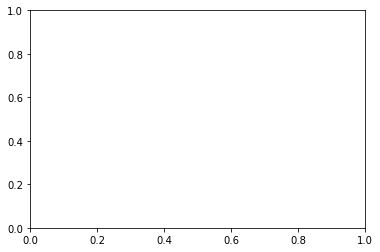

In [2]:
fig, ax = plt.subplots()
frames = []
counter = 0
path = "Data/usliverseq/volunteer01"
for i, file in enumerate(os.listdir(path)):
        if file.split('.')[-1] == "bmp":
            counter += 1
counter

In [4]:
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=1000)
HTML(ani.to_html5_video())

This dataset is from USTRackedDataset. It contains ultrasound data, which is saved as mha file. The images can be processed into numpy arrays and seem to be clear, as they recorded invitro with a machine.
They are worth exploring for training!

In [2]:
#from medpy.io import load
import SimpleITK as sitk
img = sitk.ReadImage('Data/UsTrackedDataset/DATA/babyPhantom/completeSequence/Scan02_vel_0_00125_F15N/BP_Scan02_vel_0_00125_F_15N.mha', sitk.sitkFloat32)
#mage_data, image_header = load('Data/UsTrackedDataset/DATA/babyPhantom/completeSequence/Scan02_vel_0_00125_F15N/BP_Scan02_vel_0_00125_F_15N.mha')

In [4]:
array = sitk.GetArrayFromImage(img)

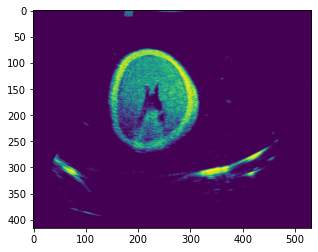

In [16]:
frames = []
fig, ax = plt.subplots()
for i in range(600):
    frames.append([ax.imshow(array[i])])

In [18]:
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=100)
HTML(ani.to_html5_video())